In [23]:
import pandas as pd
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from UKMovementSensing import hsmm

In [25]:
execfile('config.py')

## Load data

In [46]:
# Import data with states
filenames = os.listdir(states_path)
filenames = [fn for fn in filenames if os.path.isfile(os.path.join(states_path,fn))]
datasets = [pd.read_csv(os.path.join(states_path,fn), encoding='utf-8') for fn in filenames]
print(len(datasets))

103


In [47]:
#Concatenate all data together for analysis
all_data = pd.concat(datasets)

In [63]:
#Define consistent colormap
# One more than the number of states, so we have a color for 'All'
colormap, cmap = hsmm.get_color_map(all_data.state.nunique()+1)

## Calculate per-state statistics

In [62]:
bystate = all_data.groupby('state')
means = bystate[column_names].mean().transpose()
means.style.background_gradient(cmap='coolwarm',axis=1)

## Cross table activity - state

Let's compare the states with the known activities. First we have look at how many 5-seconds frame we have for each state/activity, and we sort from largest to smallest

In [49]:
ctab = pd.crosstab(all_data['act_label'], all_data['state'], margins=True).sort_values('All', ascending=False)

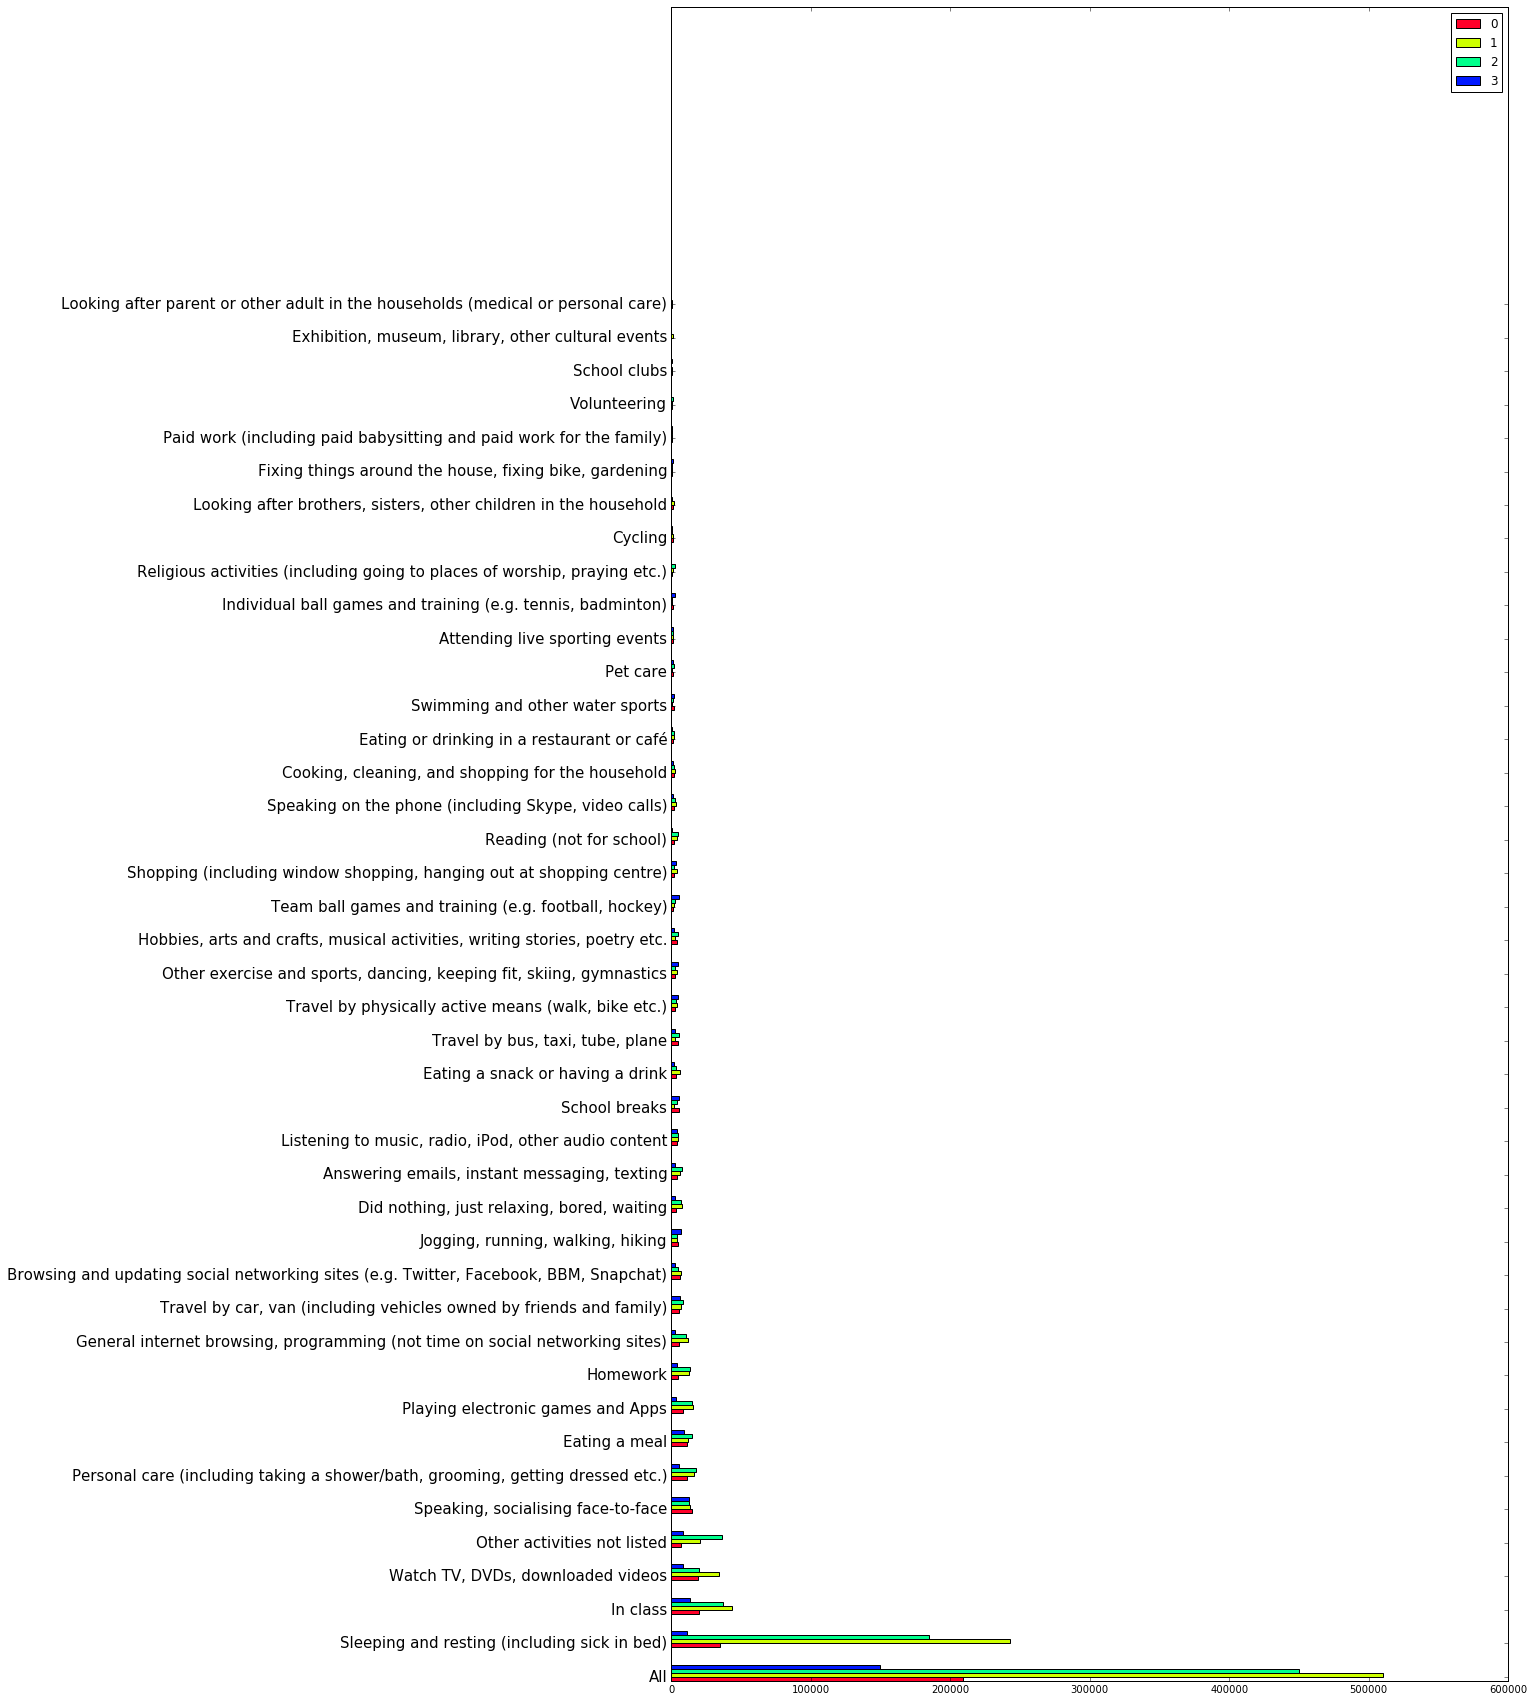

In [64]:
from __future__ import unicode_literals
fig, ax = plt.subplots(figsize=(15,30))

states = ctab.columns
acts = ctab.index

n_groups = len(acts)
index = len(states)*np.arange(n_groups)
bar_width = 1./len(states)*3
colors = colormap

#Draw all states, but don't draw All
for i in range(len(states)-1):
    rects1 = plt.barh(index + i*bar_width, 
                     ctab[states[i]], 
                     bar_width,
                     color=colors[i],
                     label=states[i])

plt.yticks(index + bar_width, ctab.index, fontsize=15)
plt.legend()

#Set maximum to something reasonable, namely the maximum of not-all
#ax.set_xlim(0, ctab[states[-1]][acts[1]])
plt.show()

In [51]:
#Now normalize over the activity and sort by total number
ind = list(ctab.index)
ctab_norm1 = pd.crosstab(all_data['act_label'], all_data['state'], normalize='index', margins=True).loc[ind]

In [52]:
ctab_norm1.style.background_gradient(cmap='BuGn',axis=1)

In [53]:
#Now normalize over state and sort by total number
ind = list(ctab.index)
ctab_norm2 = pd.crosstab(all_data['act_label'], all_data['state'], normalize='columns', margins=True).loc[ind]
ctab_norm2 = ctab_norm2.fillna(0)

In [54]:
ctab_norm2.style.background_gradient(cmap='BuGn',axis=0)

## Visualize the states spatially